In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh = 50
bs = 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
    def __repr__(self):
        return f"Lambda({self.func})"
    
def flatten(x):
    return x.view(x.shape[0], -1)

In [9]:
def mnist_resize(x): 
    return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
#         nn.Conv2d( 1, 8, 3, padding=1,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [11]:
all_entries = [i for i in iter(train_ds)]

In [12]:
img1 = all_entries[0][0]

In [13]:
model = get_cnn_model(data)

In [14]:
model

Sequential(
  (0): Lambda(<function mnist_resize at 0x7f2ae837c440>)
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda(<function flatten at 0x7f2a6e7df200>)
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [15]:
mods = [mod for mod in model.modules()]

In [16]:
x1 = mods[1](all_entries[0][0])
for i in range(len(mods) - 2):
    x1 = mods[i + 2](x1)
    print(i, mods[i + 2], x1.shape)

0 Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)) torch.Size([1, 8, 14, 14])
1 ReLU() torch.Size([1, 8, 14, 14])
2 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) torch.Size([1, 16, 7, 7])
3 ReLU() torch.Size([1, 16, 7, 7])
4 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) torch.Size([1, 32, 4, 4])
5 ReLU() torch.Size([1, 32, 4, 4])
6 Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) torch.Size([1, 32, 2, 2])
7 ReLU() torch.Size([1, 32, 2, 2])
8 AdaptiveAvgPool2d(output_size=1) torch.Size([1, 32, 1, 1])
9 Lambda(<function flatten at 0x7f2a6e7df200>) torch.Size([1, 32])
10 Linear(in_features=32, out_features=10, bias=True) torch.Size([1, 10])


In [17]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [18]:
def create_runner(model, cbfs):
    opt = optim.SGD(model.parameters(), lr=0.4)
    learn = Learner(model, opt, loss_func, data)
    run = Runner(cb_funcs=cbfs)
    return run, learn
run, learn = create_runner(model, cbfs)

In [19]:
%%time
run.fit(1, learn)

train: [1.91454625, tensor(0.3383)]
valid: [0.7179919921875, tensor(0.7922)]
CPU times: user 4.92 s, sys: 127 ms, total: 5.04 s
Wall time: 1.69 s


In [20]:
device = torch.device('cuda', 0)

In [21]:
class CudaCallback(Callback):
    def __init__(self):
        self.device = device
        
    def begin_fit(self):
        self.model.to(self.device)
        
    def begin_batch(self):
        self.run.xb = self.run.xb.to(device)
        self.run.yb = self.run.yb.to(device)

In [22]:
torch.cuda.set_device(device)

In [23]:
#export
class CudaCallback(Callback):
    def begin_fit(self):
        self.model.cuda()
        
    def begin_batch(self):
        self.run.xb = self.run.xb.cuda()
        self.run.yb = self.run.yb.cuda()

In [24]:
cbfs.append(CudaCallback)

In [25]:
model = get_cnn_model(data)

In [26]:
run, learn = create_runner(model, cbfs)

In [27]:
%%time
run.fit(3, learn)

train: [2.02408625, tensor(0.2949, device='cuda:0')]
valid: [0.9610044921875, tensor(0.6719, device='cuda:0')]
train: [0.477093125, tensor(0.8493, device='cuda:0')]
valid: [0.2492130126953125, tensor(0.9303, device='cuda:0')]
train: [0.2170396484375, tensor(0.9346, device='cuda:0')]
valid: [0.16559656982421875, tensor(0.9491, device='cuda:0')]
CPU times: user 3.47 s, sys: 469 ms, total: 3.94 s
Wall time: 3.25 s


## Refactor model

In [28]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, padding=ks // 2, stride=stride), nn.ReLU()
    )

In [29]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm):
        self.tfm = tfm
        
    def begin_batch(self):
        self.run.xb = self.tfm(self.xb)
        
def view_tfm(*size):
    def _inner(x):
        return x.view(*((-1,) + size))
    return _inner

In [30]:
mnist_view = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [31]:
nfs = [8, 16, 32, 32]

In [32]:
def get_cnn_layers(data, nfs):
    nfs =  [1] + nfs
    return [
        conv2d(nfs[i], nfs[i + 1], 5 if i == 0 else 3) for i in range(len(nfs) - 1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs):
    return nn.Sequential(*get_cnn_layers(data, nfs))

In [33]:
#export
def get_runner(model, data, lr=.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None:
        opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [34]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.4, cbs=cbfs)

In [35]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda(<function flatten at 0x7f2a6e7df200>)
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [36]:
run.fit(3, learn)

train: [2.1097871875, tensor(0.2658, device='cuda:0')]
valid: [1.547300390625, tensor(0.5175, device='cuda:0')]
train: [0.5838076171875, tensor(0.8148, device='cuda:0')]
valid: [0.240087158203125, tensor(0.9259, device='cuda:0')]
train: [0.19808005859375, tensor(0.9403, device='cuda:0')]
valid: [0.1322626220703125, tensor(0.9625, device='cuda:0')]


## Hooks

### Manual Insertion

In [37]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x
    
    def __iter__(self):
        return iter(self.layers)

In [38]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=.9, cbs = cbfs)

In [39]:
run.fit(2, learn)

train: [2.379759375, tensor(0.1373, device='cuda:0')]
valid: [2.2992880859375, tensor(0.1064, device='cuda:0')]
train: [2.01884546875, tensor(0.2684, device='cuda:0')]
valid: [1.6707900390625, tensor(0.4356, device='cuda:0')]


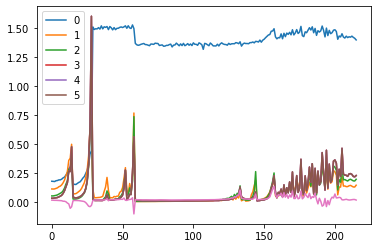

In [40]:
for l in model.act_means:
    plt.plot(l)

plt.legend(range(6))

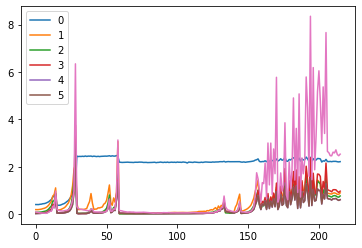

In [41]:
for l in model.act_stds:
    plt.plot(l)

plt.legend(range(6))

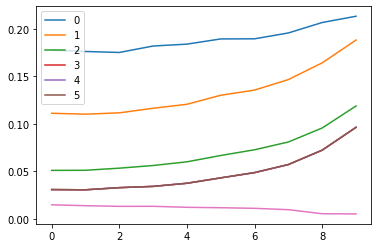

In [42]:
for l in model.act_means:
    plt.plot(l[:10])

plt.legend(range(6))

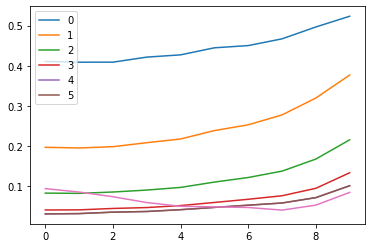

In [43]:
for l in model.act_stds:
    plt.plot(l[:10])

plt.legend(range(6))

## Pytorch Hooks

In [44]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.5, cbs = cbfs)

In [45]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [46]:
def append_stats(i, mod, inp, out):
    act_means[i].append(out.data.mean())
    act_stds[i].append(out.data.std())

In [47]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [48]:
run.fit(1, learn)

train: [1.69863578125, tensor(0.3946, device='cuda:0')]
valid: [0.42698662109375, tensor(0.8707, device='cuda:0')]


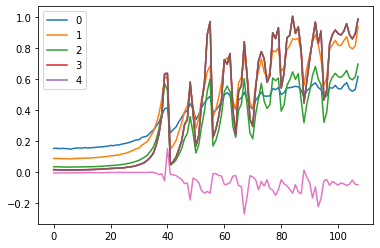

In [49]:
for o in act_means: 
    plt.plot(o)
plt.legend(range(5));

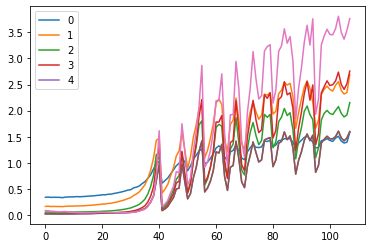

In [50]:
for o in act_stds: 
    plt.plot(o)
plt.legend(range(5));

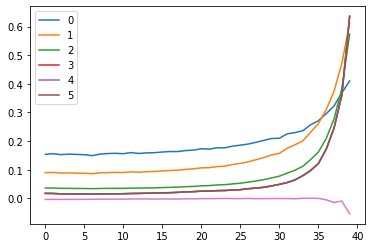

In [51]:
for l in act_means:
    plt.plot(l[:40])

plt.legend(range(6))

## Hook Class

In [52]:
#export
def children(m):
    return list(m.children())

class Hook():
    def __init__(self, model, fun):
        self.hook = model.register_forward_hook(partial(fun, self))
        
    def remove(self):
        self.hook.remove()
        
    def __del__(self):
        self.remove()
        
def append_stats(hook, mod, inp, out):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [])
    means, stds = hook.stats
    means.append(out.data.mean())
    stds.append(out.data.std())

In [53]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.5, cbs = cbfs)

In [54]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [55]:
run.fit(1, learn)

train: [1.68992390625, tensor(0.4197, device='cuda:0')]
valid: [0.402336279296875, tensor(0.8832, device='cuda:0')]


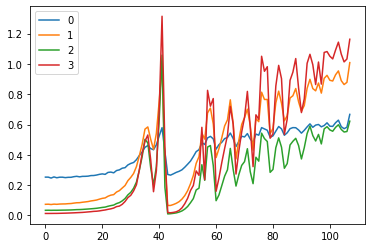

In [56]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
    
plt.legend(range(4))

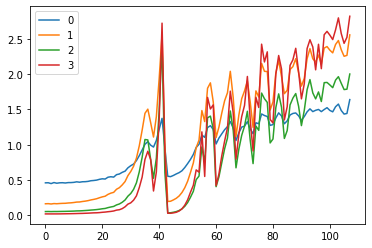

In [57]:
for h in hooks:
    plt.plot(h.stats[1])
    h.remove()
    
plt.legend(range(4))

### A Hooks class

In [58]:
#export
class ListContainer():
    def __init__(self, items):
        self.items = listify(items)
        
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)):
            return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self.items)
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    
    def __len__(self):
        return len(self.items)
    
    def __iter__(self):
        return iter(self.items)
    
    def __setitem__(self, i, o):
        self.items[i] = o
        
    def __delitem__(self, i):
        del(self.items[i])
        
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [59]:
lc = ListContainer([1,2,3])
print(len(lc))
print(lc[:2])
print(lc[[True, False, True]])
lc[1] = 10
del lc[2]
for i in lc:
    print(':', i)
lc

3
[1, 2]
[1, 3]
: 1
: 10


ListContainer (2 items)
[1, 10]

In [60]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [61]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, layers, fun):
        super().__init__([Hook(l, fun) for l in layers])
    
    def __enter__(self, *args):
        return self
    
    def __exit__(self, *args):
        self.remove()
        
    def __del__(self, *args):
        self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [62]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.9, cbs = cbfs)

In [63]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f2a5e02ffd0>, <__main__.Hook object at 0x7f2a5e02f6d0>, <__main__.Hook object at 0x7f2a5e02f0d0>, <__main__.Hook object at 0x7f2a5e02f2d0>, <__main__.Hook object at 0x7f2a5e02f8d0>, <__main__.Hook object at 0x7f2a5e142e10>, <__main__.Hook object at 0x7f2a5e029310>]

In [64]:
run.fit(1, learn)

train: [2.241719375, tensor(0.1719, device='cuda:0')]
valid: [2.2975501953125, tensor(0.1165, device='cuda:0')]


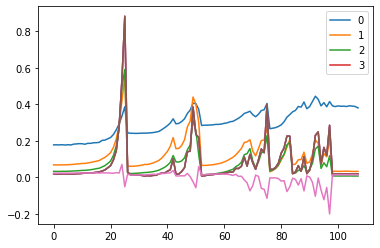

In [65]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
    
plt.legend(range(4))

In [66]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.9, cbs = cbfs)

In [67]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f2a5de8bf90>, <__main__.Hook object at 0x7f2a5de8bcd0>, <__main__.Hook object at 0x7f2a5de8bb50>, <__main__.Hook object at 0x7f2a5de8ba10>, <__main__.Hook object at 0x7f2a5e02f650>, <__main__.Hook object at 0x7f2a5def8450>, <__main__.Hook object at 0x7f2a5def8bd0>]

In [68]:
model.cuda()
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [69]:
x.mean(), x.std()

(tensor(0.0121, device='cuda:0'), tensor(1.0127, device='cuda:0'))

In [70]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.2010, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4161, device='cuda:0', grad_fn=<StdBackward0>))

In [71]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [72]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4535, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9319, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.88398703125, tensor(0.3478, device='cuda:0')]
valid: [0.73230390625, tensor(0.7762, device='cuda:0')]
train: [0.362362109375, tensor(0.8866, device='cuda:0')]
valid: [0.1672526611328125, tensor(0.9517, device='cuda:0')]


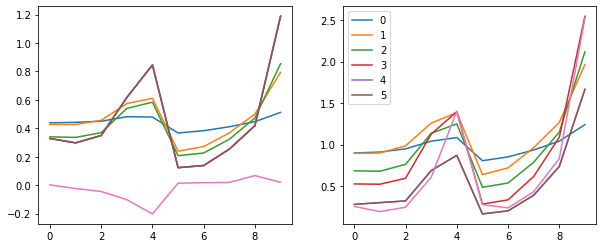

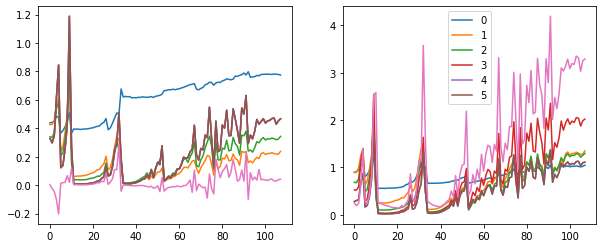

In [73]:
def plot_ms_ss(hooks, slice_):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax1.plot(ms[slice_])
        ax2.plot(ss[slice_])
    plt.legend(range(6))

with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    plot_ms_ss(hooks, slice(0, 10))
    plot_ms_ss(hooks, slice(0, len(h.stats[0])))

### Other statistics

In [74]:
def append_stats_main(hook, mod, inp, outp, histc1, histc2, histc3):
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(histc1,histc2,histc3)) #histc isn't implemented on the GPU

def append_stats(hook, mod, inp, outp):
    append_stats_main(hook, mod, inp, outp, 40,0,10)

In [75]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.9, cbs = cbfs)

In [76]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [77]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)

train: [1.215072109375, tensor(0.5988, device='cuda:0')]
valid: [0.2530240234375, tensor(0.9248, device='cuda:0')]


In [78]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): 
    return torch.stack(h.stats[2]).t().float().log1p()

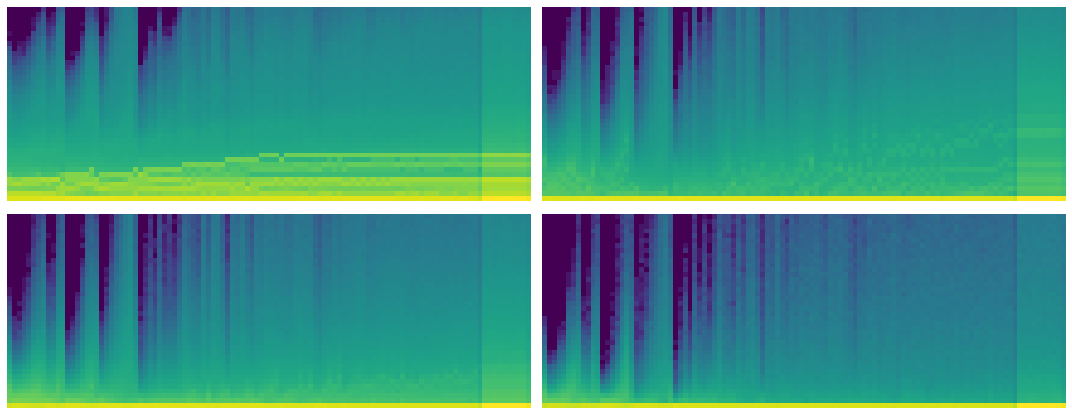

In [79]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [80]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0) / h1.sum(0)

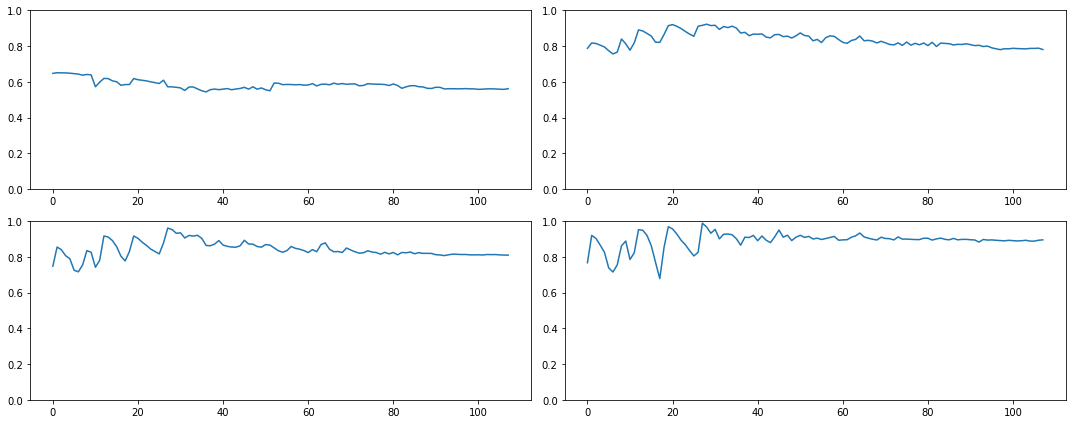

In [81]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

In [82]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i + 1], 5 if i == 0 else 3, **kwargs) for i in range(len(nfs)-1)] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

In [83]:
#export
def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

In [84]:
#export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None:
            x.sub_(self.sub)
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x   

In [85]:
#export
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=.1)
            l[0].bias.data.zero_()

In [86]:
#export
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [87]:
def append_stats(hook, mod, inp, outp):
    append_stats_main(hook, mod, inp, outp, 40,-7,7)

In [88]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.436711015625, tensor(0.8658, device='cuda:0')]
valid: [0.15338409423828125, tensor(0.9545, device='cuda:0')]


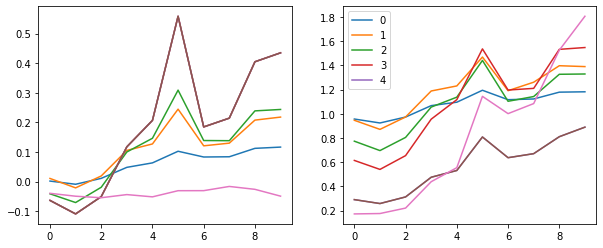

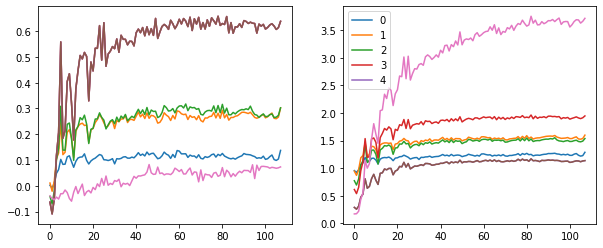

In [89]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax1.plot(ms[:10])
        ax2.plot(ss[:10])
        h.remove()
    plt.legend(range(5))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax1.plot(ms[:])
        ax2.plot(ss[:])
        h.remove()
    plt.legend(range(5))

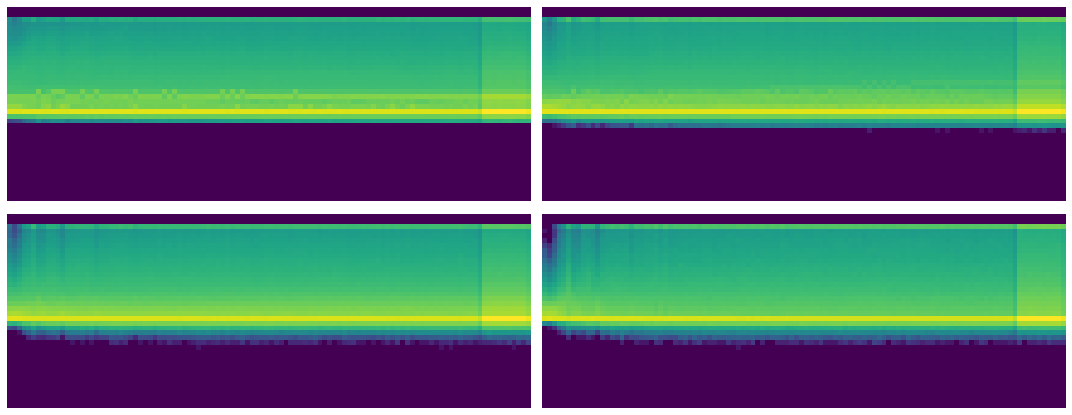

In [90]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [91]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

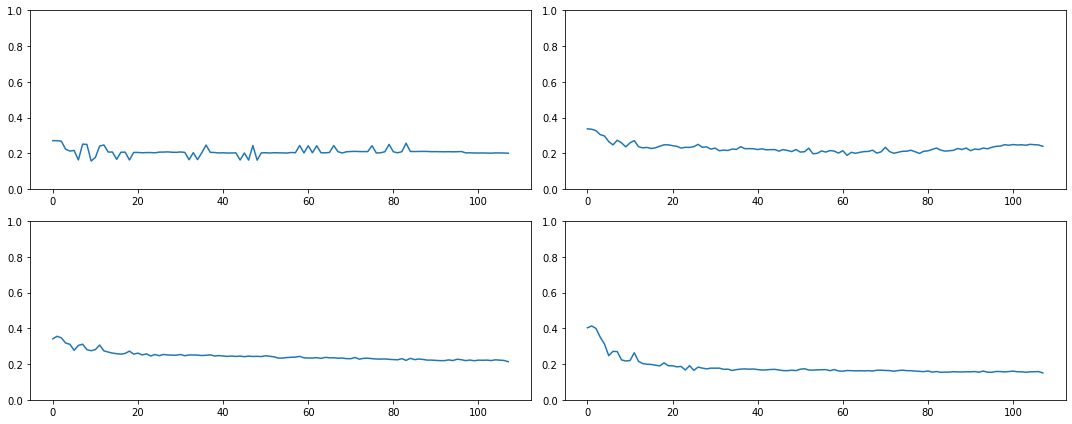

In [92]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [93]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [94]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [95]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

In [96]:
run.fit(8, learn)

train: [1.250081015625, tensor(0.5896, device='cuda:0')]
valid: [0.3092280029296875, tensor(0.9104, device='cuda:0')]
train: [0.33847171875, tensor(0.8989, device='cuda:0')]
valid: [0.1564182861328125, tensor(0.9545, device='cuda:0')]
train: [0.68628875, tensor(0.7849, device='cuda:0')]
valid: [0.2624972412109375, tensor(0.9189, device='cuda:0')]
train: [0.17250150390625, tensor(0.9467, device='cuda:0')]
valid: [0.21352109375, tensor(0.9333, device='cuda:0')]
train: [0.10728185546875, tensor(0.9669, device='cuda:0')]
valid: [0.08491248168945313, tensor(0.9755, device='cuda:0')]
train: [0.071513115234375, tensor(0.9779, device='cuda:0')]
valid: [0.082908349609375, tensor(0.9767, device='cuda:0')]
train: [0.05340861328125, tensor(0.9838, device='cuda:0')]
valid: [0.07305382690429688, tensor(0.9794, device='cuda:0')]
train: [0.0450459228515625, tensor(0.9868, device='cuda:0')]
valid: [0.071430615234375, tensor(0.9811, device='cuda:0')]


In [97]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [98]:
run.fit(8, learn)

train: [1.066964765625, tensor(0.6626, device='cuda:0')]
valid: [0.371622265625, tensor(0.8960, device='cuda:0')]
train: [0.3315750390625, tensor(0.9002, device='cuda:0')]
valid: [0.1765378173828125, tensor(0.9457, device='cuda:0')]
train: [0.18525171875, tensor(0.9440, device='cuda:0')]
valid: [0.1229348388671875, tensor(0.9630, device='cuda:0')]
train: [1.117797890625, tensor(0.6291, device='cuda:0')]
valid: [0.44267255859375, tensor(0.8659, device='cuda:0')]
train: [0.25243876953125, tensor(0.9214, device='cuda:0')]
valid: [0.12110814208984375, tensor(0.9644, device='cuda:0')]
train: [0.104962255859375, tensor(0.9678, device='cuda:0')]
valid: [0.09641316528320312, tensor(0.9724, device='cuda:0')]
train: [0.0756229248046875, tensor(0.9771, device='cuda:0')]
valid: [0.08307163696289062, tensor(0.9769, device='cuda:0')]
train: [0.063618330078125, tensor(0.9805, device='cuda:0')]
valid: [0.080512255859375, tensor(0.9775, device='cuda:0')]


In [99]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [ ]:
nb_auto_export()